<a href="https://colab.research.google.com/github/kimdonggyu2008/SKT_FLY_AI_6/blob/main/unet%EB%94%B0%EB%9D%BC%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk, rectangle

In [25]:
def create_image_with_shapes_and_labels(image_size=(256,256)):
  image=np.zeros((*image_size,3),dtype=np.float32)
  label=np.zeros(image_size,dtype=np.int64)

  rr,cc=disk((64,64),40)
  image[rr,cc,0]=1.0
  label[rr,cc]=1

  start=(120,120)
  extent=(50,80)

  rr,cc=rectangle(start,extent)
  image[rr,cc,1]=1.0
  label[rr,cc]=2

  image = (image - image.min()) / (image.max() - image.min()) #정규화
  return torch.tensor(image).permute(2, 0, 1), torch.tensor(label)

In [26]:
def double_conv(in_channels,out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

In [35]:
class UNet(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(UNet,self).__init__()

    self.enc1=double_conv(in_channels,64)
    self.enc2=double_conv(64,128)
    self.enc3=double_conv(128,256)
    self.enc4=double_conv(256,512)

    self.bottleneck=double_conv(512,1024)

    self.unconv4=nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
    self.dec4=double_conv(1024,512)

    self.unconv3=nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
    self.dec3=double_conv(512,256)

    self.unconv2=nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
    self.dec2=double_conv(256,128)


    self.unconv1=nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
    self.dec1=double_conv(128,64)

    self.out_conv=nn.Conv2d(64,out_channels,kernel_size=1)


  def forward(self,x):
    enc1=self.enc1(x)
    enc2=self.enc2(nn.MaxPool2d(kernel_size=2)(enc1))
    enc3=self.enc3(nn.MaxPool2d(kernel_size=2)(enc2))
    enc4=self.enc4(nn.MaxPool2d(kernel_size=2)(enc3))

    bottleneck=self.bottleneck(nn.MaxPool2d(kernel_size=2)(enc4))

    dec4=self.unconv4(bottleneck)
    dec4=torch.cat((enc4,dec4),dim=1)
    dec4=self.dec4(dec4)

    dec3=self.unconv3(dec4)
    dec3=torch.cat((enc3,dec3),dim=1)
    dec3=self.dec3(dec3)

    dec2=self.unconv2(dec3)
    dec2=torch.cat((enc2,dec2),dim=1)
    dec2=self.dec2(dec2)

    dec1=self.unconv1(dec2)
    dec1=torch.cat((enc1,dec1),dim=1)
    dec1=self.dec1(dec1)

    out=self.out_conv(dec1)
    return out

In [36]:
# Training loop
def train_model(model, optimizer, criterion, num_epochs, input_image, ground_truth):
    model.train() #학습모델
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_image)#모델 예측값
        loss = criterion(outputs, ground_truth.unsqueeze(0))  # Add batch dimension to ground_truth

        # Backward pass
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    print("Training complete!")

In [37]:
# Visualization of results
def visualize_results(input_image, output_prediction, ground_truth=None):
    input_image = input_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to HWC
    output_prediction = torch.argmax(output_prediction, dim=1).squeeze().cpu().numpy()  # Convert to label map
    if ground_truth is not None:
        ground_truth = ground_truth.cpu().numpy()

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(input_image)
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    ax[1].imshow(output_prediction, cmap="jet")
    ax[1].set_title("Model Prediction")
    ax[1].axis("off")

    if ground_truth is not None:
        ax[2].imshow(ground_truth, cmap="jet")
        ax[2].set_title("Ground Truth")
        ax[2].axis("off")

    plt.tight_layout()
    plt.show()

Epoch [1/10], Loss: 1.2367
Epoch [2/10], Loss: 0.8638
Epoch [3/10], Loss: 0.7396
Epoch [4/10], Loss: 0.7094
Epoch [5/10], Loss: 0.6904
Epoch [6/10], Loss: 0.6750
Epoch [7/10], Loss: 0.6573
Epoch [8/10], Loss: 0.6391
Epoch [9/10], Loss: 0.6181
Epoch [10/10], Loss: 0.5974
Training complete!


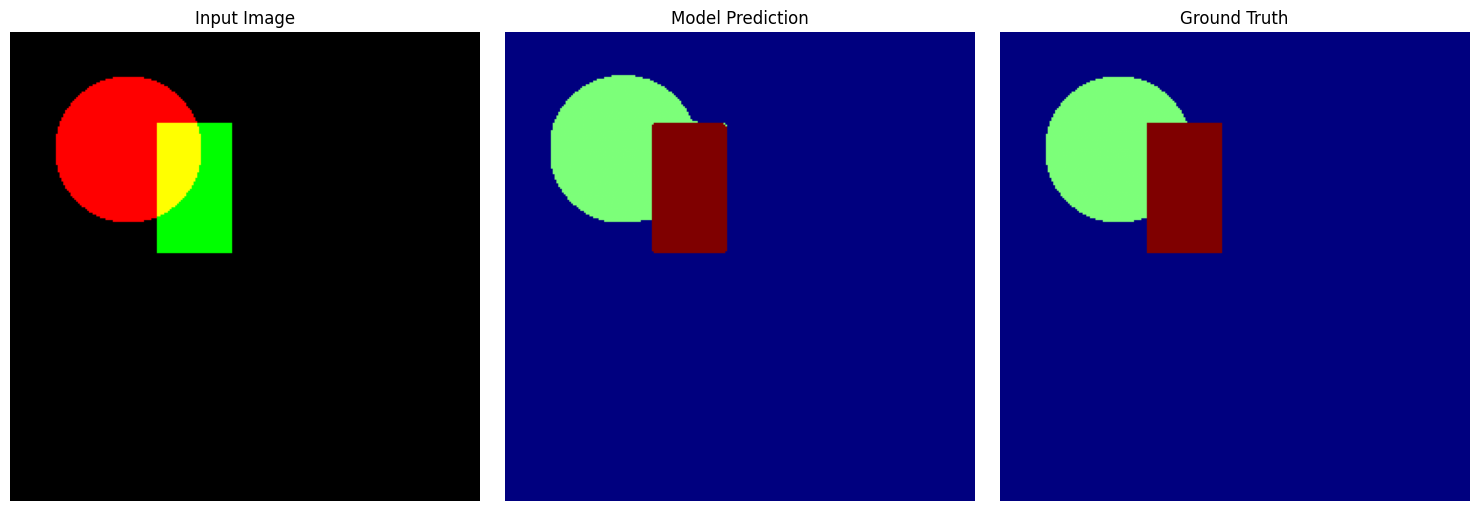

In [38]:
# Example usage
if __name__ == "__main__":
    # Create synthetic data
    input_image, ground_truth = create_image_with_shapes_and_labels()
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    ground_truth = ground_truth  # (H, W)

    # Instantiate U-Net model
    num_classes = 3  # Background, Circle, Rectangle
    #model = UNet(in_channels=3, out_channels=num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(in_channels=3, out_channels=num_classes).to(device)
    input_image = input_image.to(device)
    ground_truth = ground_truth.to(device)


    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, optimizer, criterion, num_epochs=10, input_image=input_image, ground_truth=ground_truth)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        output_prediction = model(input_image)

    # Visualize results
    visualize_results(input_image.squeeze(), output_prediction, ground_truth)